# Unbiased Quantum Galton Board: Simulating Probability Distributions
This notebook implements an `unbiased quantum Galton circuit` that functions as a quantum version of the `classical Galton board`, widely known for demonstrating fundamental statistical principles such as the `central limit theorem`. Unlike biased variations, this unbiased circuit producing Normal probability Distribution for all measurement outcomes, accurately mimicking a universal statistical simulator. The design leverages a minimal set of quantum gates to create superpositions representing all possible trajectories of a quantum Galton board. This unbiased model is crucial for exploring universal statistical phenomena, as it can be extended to emulate classical and quantum stochastic processes with `high fidelity`.


## Setup and Installation

To run the quantum circuit simulation and related analyses in this notebook, ensure you have the required `Python packages` installed.

In [1]:
!pip install numpy scipy qiskit qiskit qiskit_aer matplotlib pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.7 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=4c40d47a23fc7528bf44a1998375cd0e353c1cc4933eb399930b27e659e95a67
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [2]:
import collections
import pylatexenc
import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator
from matplotlib import pyplot as plt
from qiskit.visualization import plot_histogram
from scipy.stats import norm

#Functions

###Quantum Walk Step: One Peg Galton Board

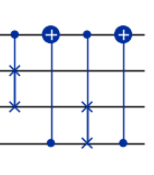
<br>Circuit diagram illustrates the core step of a quantum Galton board's walk over one peg. The sequence uses two `controlled-SWAP (cswap)` gates and two `controlled-NOT (cx)` gates. The control qubit directs swaps Between Neighbouring "target" qubits, simulating paths in the Galton board.

The final CNOT gate is `excluded` from the last step of each walk.

This omission is intentional and serves as an optimisation: Skipping the last cx avoids an `unnecessary entanglemen`t that would otherwise need to be immediately turned to $|0$> restoring the control qubit to its original state.

In [3]:
def one_peg_galton_board(
    qc: QuantumCircuit,
    control_qubit: QuantumRegister,
    target_q_reg: QuantumRegister,
    center_idx: int,
    j: int,
    is_last_step: bool
):
    """
    Applies one step of the controlled-swaps sequence which illustrates one peg in a certain level forms the core of the
    quantum wala. This function encapsulates the four-gate sequence

    Args:
        qc: The QuantumCircuit to add gates to.
        control_qubit: The qubit controlling the operations.
        target_q_reg: The register on which the walk occurs.
        center_idx: The index of the center qubit in target_q_reg.
        j: The offset from the center for the current step.
        is_last_step: A boolean to prevent adding a final CNOT.
    """
    # Define the three qubits involved in this step
    qubit_A = target_q_reg[center_idx + j - 1]
    qubit_B = target_q_reg[center_idx + j]
    qubit_C = target_q_reg[center_idx + j + 1]

    # The Quantum circuit for 1 peg step
    qc.cswap(control_qubit, qubit_A, qubit_B)
    qc.cx(qubit_B, control_qubit)
    qc.cswap(control_qubit, qubit_B, qubit_C)

    # The final CNOT is omitted on the last step of the inner loop for optimization purpose
    if not is_last_step:
        qc.cx(qubit_C, control_qubit)

###Unbiased Galton Board Circuit

In [6]:
def Unbiased_Galton_board_circuit(level: int) -> QuantumCircuit:
    """
    Builds the complete quantum galton board circuit in a structured and modular way.

    Args:
        level: No. of levels in Galton board

    Returns:
        The fully constructed Quantum Galton Board Circuit object.
    """

    # 1. SETUP: Define quantum and classical registers
    num_qubits = 2 * (level + 1) # Number of qubits needed for the walk space
    q = QuantumRegister(num_qubits, "q")
    c = ClassicalRegister(level + 1, "c")
    circuit = QuantumCircuit(q, c) # Create the quantum circuit

    # Define key qubit indices
    control_qubit = q[0]
    center_qubit_index = level + 1 # This is the starting position index

    # 2. INITIAL STATE: Prepare the system
    '''Set the qubit at the center_qubit_index to the |1> state.
       This initializes the walk at the central position in the quantum walk space'''

    circuit.x(q[center_qubit_index])

    # 3. ALGORITHM: Build the main logic of the circuit
    for i in range(level):
        circuit.reset(control_qubit)
        circuit.h(control_qubit)
        indices = list(range(-i, i+1, 2))
        '''Get list of relative position of individual peg circuit relative to center qubit for a particular value of i(level)
           Example:
          - i=0 -> [0]
          - i=1 -> [-1, 1]
          - i=2 -> [-2, 0, 2]
          - i=3 -> [-3,-1,1,3]'''
        # Apply the quantum walk step (one peg operation) for each relevant position in the current level
        for step_index, j in enumerate(indices):
            # Check if this is the last step in the inner loop for optimization
            is_last = (step_index == len(indices) - 1)
            one_peg_galton_board(
                qc=circuit,
                control_qubit=control_qubit,
                target_q_reg=q,
                center_idx=center_qubit_index,
                j=j,
                is_last_step=is_last
            )
    circuit.barrier()

    # 4. MEASUREMENT: Measure the desired qubits to get the result
    qubits_to_measure = [q[i] for i in range(num_qubits) if i % 2 != 0]
    circuit.measure(qubits_to_measure, c) # Measure the selected qubits into the classical register

    return circuit

#Simulation and Visualisation

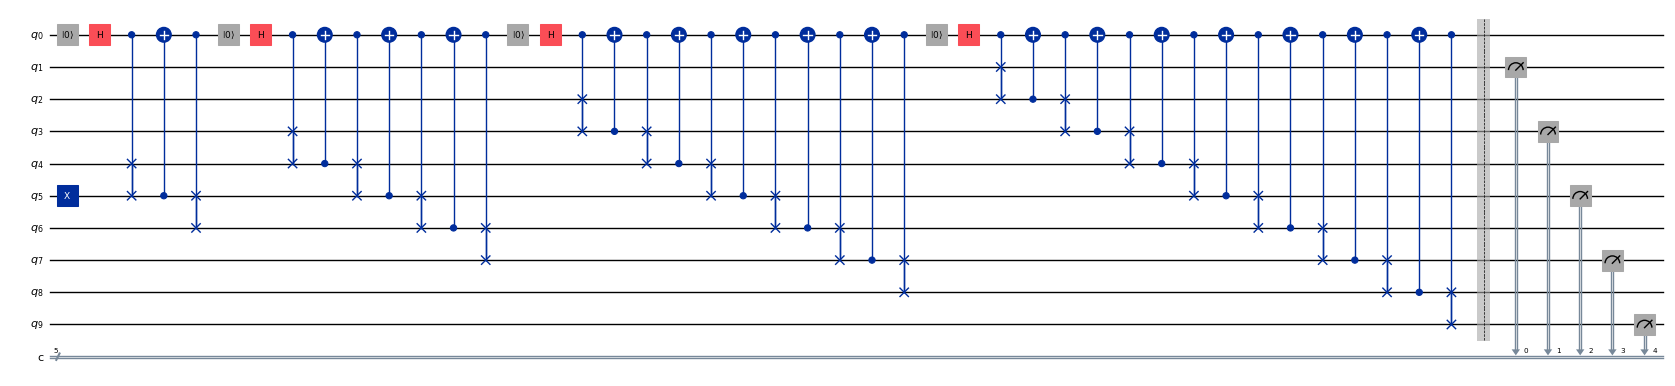

In [7]:
# Set the level for the circuit
circuit_level = 4

# Build the circuit
my_circuit = Unbiased_Galton_board_circuit(level=circuit_level)
my_circuit.draw('mpl',scale=0.5,fold=100)

The `AerSimulator` is used to execute the circuit "my_circuit" for `2000 shots` (repetitions). The AerSimulator in Qiskit is a high-performance `quantum circuit simulator` designed to mimic `real quantum devices`. It can simulate an ideal, `noiseless environment` and also `realistic noisy conditions` by incorporating various noise models.

Measurement counts (no noise): {'00001': 122, '01000': 515, '00010': 525, '10000': 119, '00100': 719}


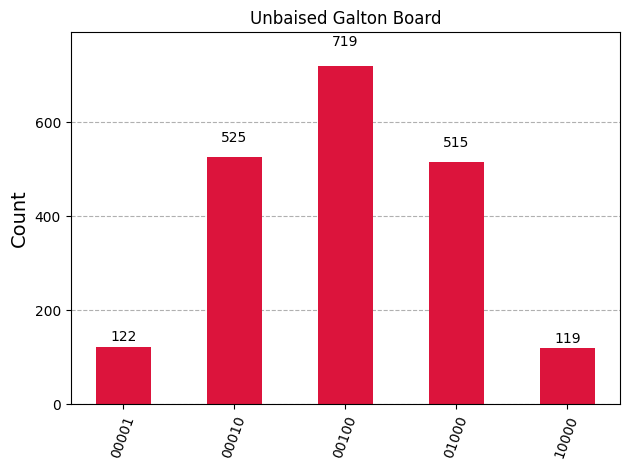

In [8]:
# 2. Execute simulation on the Aer simulator (ideal, noiseless)
sim = AerSimulator(method='matrix_product_state')
result = sim.run(my_circuit, shots=2000).result()
counts = result.get_counts()

# 3. Display results as a histogram
print("Measurement counts (no noise):", counts)
plot_histogram(counts, bar_labels=True, color=['crimson'],
                title="Unbaised Galton Board")

##Post-Processing

In [9]:
circuit_level = 4
normal_distribution_circuit = Unbiased_Galton_board_circuit(level=circuit_level)
result = sim.run(normal_distribution_circuit, shots=40000,memory=True).result()
measurement_results=result.get_memory(normal_distribution_circuit)


In [10]:
def histogram_binning(output:list,level:int,block_size=8):
    """
    Processes a list of measurement outcomes (bitstrings) and bins them
    by summing up the integer value of mapped outcomes within specified blocks.

    Args:
        output: A list of measurement outcome bitstrings.
        level: The number of levels in the Galton board, used for bitstring to integer mapping.
        block_size: The number of outcomes to group together for summation.(Defalut:8)

    Returns:
        A list of summed integer values for each block of outcomes.
    """
    shots=len(output) # Get the total number of measurement shots
    bitstring_to_int = {'0' * (level - i) + '1' + '0' * i: i for i in range(level+1)}

    # Map each outcome bitstring to its corresponding integer value using the defined mapping.
    mapped_outputs = np.array([bitstring_to_int.get(o, 0) for o in output])

    # This creates a new list where each element is the sum of mapped outcomes in a block.
    return [sum(mapped_outputs[i:i+block_size]) for i in range(0, shots, block_size)]

/tmp/ipython-input-2684842949.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, pdf, 'k', linewidth=2, label=f'Normal fit\nμ={mu:.2f}, σ={sigma:.2f}', color='blue')


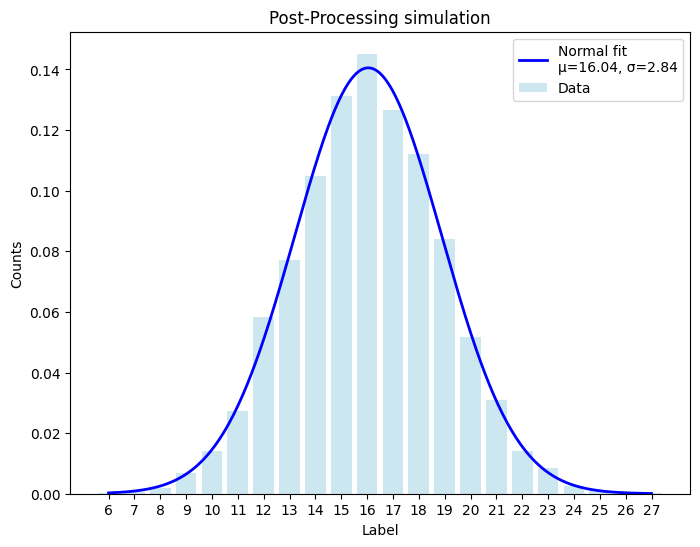

In [19]:
# your histogram data
data = histogram_binning(measurement_results, circuit_level)
frequency = collections.Counter(data)
sorted_labels = sorted(frequency.keys())
sorted_counts = [frequency[label] for label in sorted_labels]
sorted_counts=[x / len(data) for x in sorted_counts]
chart_labels = np.array(sorted_labels)

# plot histogram
plt.figure(figsize=(8, 6))
plt.bar(chart_labels, sorted_counts, color='lightblue', alpha=0.6, label='Data')

# fit normal distribution parameters (mean, std) from the data
mu, sigma = norm.fit(data)  # uses raw measurement results

# create smooth curve for the normal distribution
x = np.linspace(min(chart_labels), max(chart_labels), 500)
pdf = norm.pdf(x, mu, sigma)

# plot normal curve
plt.plot(x, pdf, 'k', linewidth=2, label=f'Normal fit\nμ={mu:.2f}, σ={sigma:.2f}', color='blue')
plt.xlabel("Label")
plt.ylabel("Counts")
plt.title("Post-Processing simulation")
plt.xticks(np.arange(min(chart_labels), max(chart_labels) + 1, 1))
plt.legend()
plt.show()